[[np.float64(3.960009922952013), np.float64(2.7189052758235457), np.float64(1.64998991301593), np.float64(0.6864971473751081)], [np.float64(5.301028306521587), np.float64(3.2546993548467675), np.float64(1.7816524948955066), np.float64(0.705750460590899)]]


Text(0.5, 1.0, 'Throughput of different output lengths (input length = 1038)')

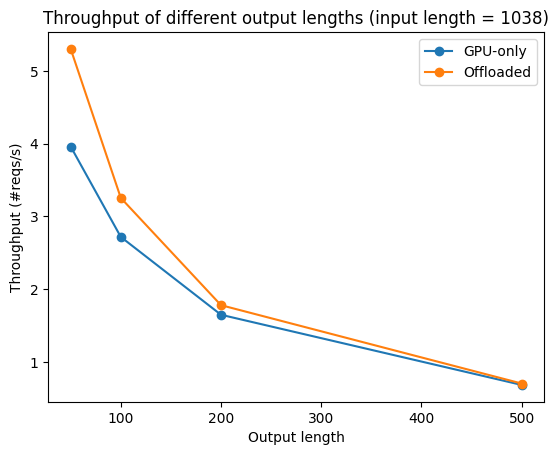

In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

# in_len = 2542
# num_data = 1000
# output_lens = [30, 50, 70, 90]

in_len = 1038
num_data = 2000
output_lens = [50, 100, 200, 500]

tps = [[], []]

for out_len in output_lens:
  path_prefix = '../data/d1016/'
  file_names = [f'{num_data}-{in_len}-{out_len}-True.json', f'{num_data}-{in_len}-{out_len}-False.json']
  # file_names = [f'{num_data}-{out_len}-True.json', f'{num_data}-{out_len}-False.json']
  file_names = [path_prefix + f for f in file_names]
  for i, filename in enumerate(file_names):
    with open(filename) as f:
      data = json.load(f)['req_end_deltas']

    ndata = len(data)
    nwarmup = (ndata + 1) // 10
    ncooldown = (ndata + 1) // 10 * 8
    tps[i].append(1 / np.mean(data[nwarmup: ncooldown]))
  
print(tps)

plt.plot(output_lens, tps[0], label='GPU-only', marker='o')
plt.plot(output_lens, tps[1], label='Offloaded', marker='o')

plt.xlabel('Output length')
plt.ylabel('Throughput (#reqs/s)')
plt.legend()
plt.title(f'Throughput of different output lengths (input length = {in_len})')

total time: 610.6720350384712


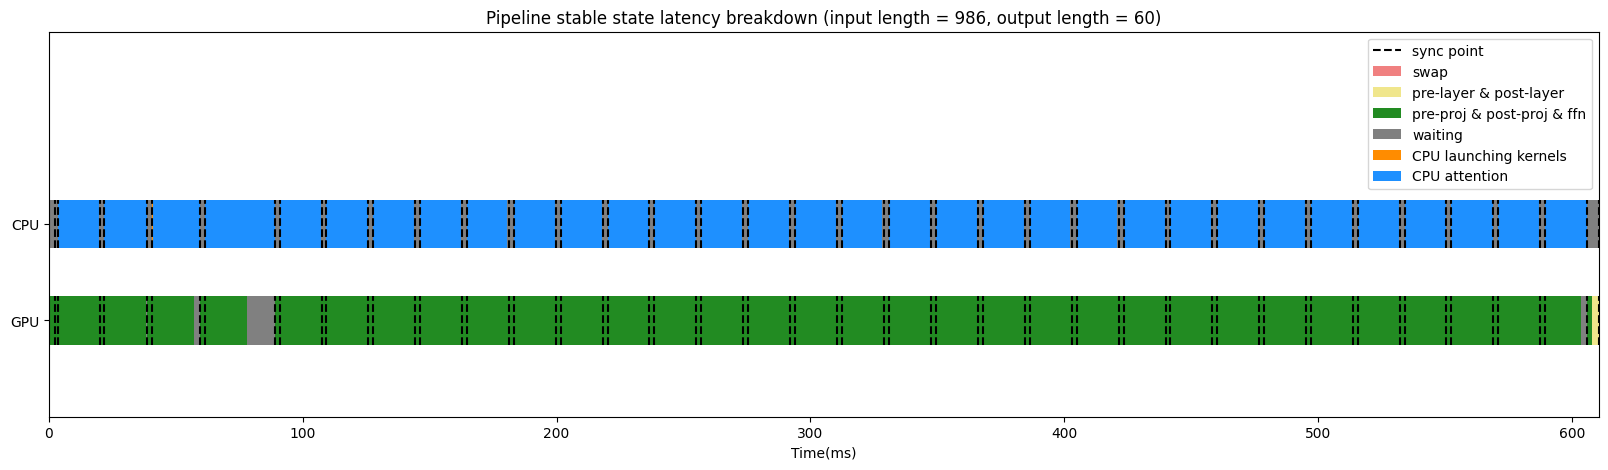

In [4]:
import json
import numpy as np

swapin_time = 0
swapout_time = 0

def barh_accum(ys, xs, left, color, label):
  """
  Accumulate the barh chart.
  """
  plt.barh(ys, xs, left=left, color=color, height=0.5, label=label)
  return np.array(xs) + left

def barh_sync(ys, left):
  """
  make 2 bars sync.
  """
  maxx = max(left)
  ret = barh_accum(ys, maxx - left, left, "grey", label="waiting")
  # print a sync line
  plt.vlines([maxx]*2, [-0.25, 0.75], [0.25, 1.25], color="black", linestyle="--", label="sync point")
  return ret


def pipeline_batch_breakdown(last: int):
  """
  Break down graph for pipeline batch.
  """
  with open("breakdown.json", "r") as f:
    data = json.load(f)
  
  linear_times = np.array(data["linear_times"])
  cpuwrk_times = np.array(data["cpuwrk_times"])
  cpudec_times = np.array(data["cpudec_times"])
  cpuwait_times = cpuwrk_times - cpudec_times
  assert cpuwait_times.min() >= 0

  ys = ["GPU", "CPU"]
  left = np.array([0, 0])

  # Swap-in
  left = barh_accum(ys, [swapin_time, swapin_time], left, color="lightcoral", label="swap")

  # Beginning
  left = barh_accum(ys, [data["prelayer_time"], 0], left, color="khaki", label="pre-layer & post-layer")
  first_stage_time = data["first_stage_time"]
  first_preproj_time = first_stage_time - max(linear_times[-1], cpuwrk_times[-1])
  left = barh_accum(ys, [first_preproj_time, 0], left, color="forestgreen", label="pre-proj & post-proj & ffn")
  left = barh_sync(ys, left)

  # Middle
  for i in range(-1, last - 1):
    left = barh_accum(ys, [linear_times[i], 0], left, color="forestgreen", label="pre-proj & post-proj & ffn")
    left = barh_accum(ys, [0, cpuwait_times[i]], left, color="darkorange", label="CPU launching kernels")
    left = barh_accum(ys, [0, cpudec_times[i]], left, color="dodgerblue", label="CPU attention")
    left = barh_sync(ys, left)

  if last == 64:
    last_stage_time = data["last_stage_time"]
    last_postproj_time = last_stage_time - max(linear_times[-2], cpuwrk_times[-2])
    left = barh_accum(ys, [last_postproj_time, 0], left, color="forestgreen", label="pre-proj & post-proj & ffn")
    left = barh_accum(ys, [data["postlayer_time"], 0], left, color="khaki", label="pre-layer & post-layer")
    left = barh_sync(ys, left)

    # Swap-out
    left = barh_accum(ys, [swapout_time, swapout_time], left, color="lightcoral", label="swap")

  plt.xlabel("Time(ms)")
  plt.ylim(-1, 3)
  plt.title("Pipeline stable state latency breakdown (input length = 986, output length = 60)")

  print(f"total time: {left[0]}")

plt.figure(figsize=(20, 5))
pipeline_batch_breakdown(64)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

  

Text(0.5, 1.0, 'Avg latency of different request rates (input:output = 454:40)')

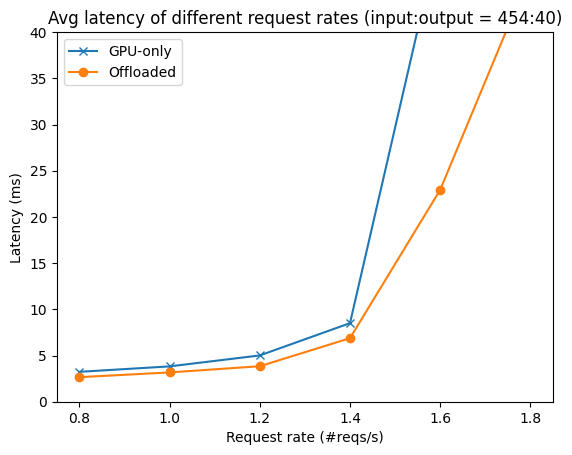

In [7]:
import matplotlib.pyplot as plt

req_rates = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
lat0 = [3.235, 3.825, 5.010, 8.503, 50.819, 81.679]
lat1 = [2.658, 3.171, 3.841, 6.876, 22.929, 46.402]

plt.plot(req_rates, lat0, label='GPU-only', marker='x')
plt.plot(req_rates, lat1, label='Offloaded', marker='o')

plt.xlabel('Request rate (#reqs/s)')
plt.ylabel('Latency (ms)')
plt.ylim(0, 40)
plt.legend()
plt.title('Avg latency of different request rates (input:output = 454:40)')

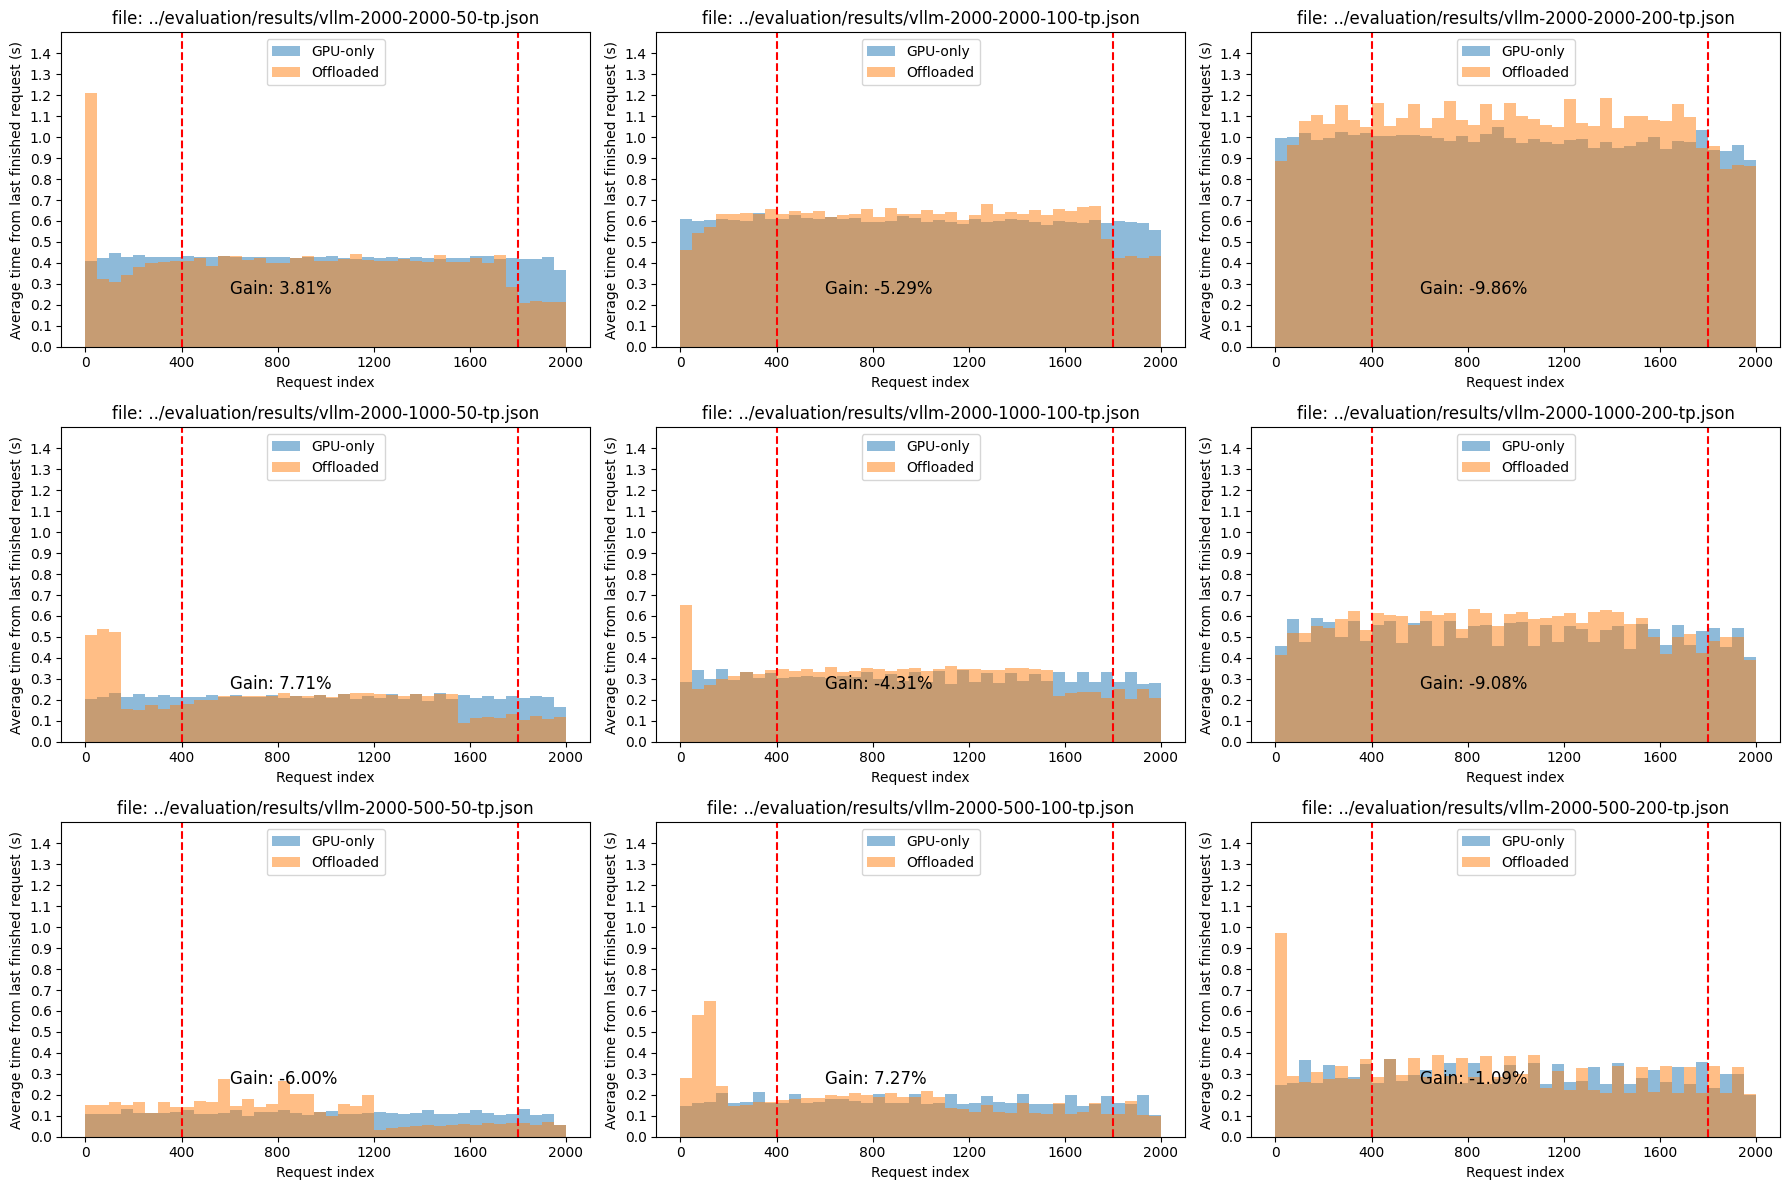

In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt

# path_prefix = '../data/d1017/'
path_prefix = '../evaluation/results/'

def draw_req_bar_diagram(file_names, ax: plt.Axes):
  # file_names = [f'{num_data}-{in_len}-{out_len}-True.json', f'{num_data}-{in_len}-{out_len}-False.json']
  # file_names = [f'{num_data}-{out_len}-True.json', f'{num_data}-{out_len}-False.json']
  file_names = [path_prefix + f for f in file_names]
  througputs = []
  for i, filename in enumerate(file_names):
    with open(filename) as f:
      data = json.load(f)['req_end_deltas']

    # Draw bar diagram, cut data into 10 bins and calculate average of each bin
    ndata = len(data)
    nwarmup = (ndata + 1) // 10 * 2
    ncooldown = (ndata + 1) // 10 * 7
    nseg = 40
    seg_len = (ndata + 1) // nseg
    xs = range(0, ndata, seg_len)
    ax.bar(
      xs, 
      [np.mean(data[x:x+seg_len]) for x in xs], 
      width=seg_len, 
      align='edge', 
      alpha=0.5, 
      label='Offloaded' if i == 1 else 'GPU-only'
    )

    througputs.append(1 / np.mean(data[nwarmup: ncooldown]))

  ax.axvline(x=nwarmup, color='r', linestyle='dashed')
  ax.axvline(x=ncooldown, color='r', linestyle='dashed')
              
  ndisp_seg = 5
  disp_seg_len = (ndata + 1) // ndisp_seg
  ax.set_xticks(list(range(0, ndata, disp_seg_len)) + [ndata + 1])
  ax.set_yticks([i * 0.1 for i in range(15)])
  ax.set_ylim(0, 1.5)
  ax.set_xlabel('Request index')
  ax.set_ylabel('Average time from last finished request (s)')
  ax.legend()
  ax.title.set_text(f'file: {file_names[0]}')

  gain = througputs[1] / througputs[0] - 1
  ax.text(ndata * 0.3, 0.25, f'Gain: {gain*100:.2f}%', fontsize=12)

def draw_req_bar_diagram_mock(in_len, out_len, ax: plt.Axes):
  file_names = [f'vllm-{num_data}-{in_len}-{out_len}-tp.json', f'ours-{num_data}-{in_len}-{out_len}-tp.json']
  draw_req_bar_diagram(file_names, ax)

def draw_req_bar_diagram_real(name: str, ax: plt.Axes):
  file_names = [f'vllm-{name}-tp.json', f'ours-{name}-tp.json']
  draw_req_bar_diagram(file_names, ax)


def draw_itr_bar_diagram(in_len, out_len, ax: plt.Axes):
  file_names = [f'{num_data}-{in_len}-{out_len}-True.json', f'{num_data}-{in_len}-{out_len}-False.json']
  # file_names = [f'{num_data}-{in_len}-{out_len}-False.json']
  # file_names = [f'{num_data}-{out_len}-True.json', f'{num_data}-{out_len}-False.json']
  file_names = [path_prefix + f for f in file_names]
  througputs = []
  for i, filename in enumerate(file_names):
    with open(filename) as f:
      data = json.load(f)
      times = data['itr_end_times']
      ntoks = data['ntoken_of_itr']

    # Draw bar diagram, cut data into 10 bins and calculate average of each bin
    seg_len = 10
    cur_time = 0
    cur_iter = 0
    seg_starts = []
    ntok_of_seg = []
    while cur_time < times[-1]:
      seg_starts.append(cur_time)
      cur_ntok = 0
      while cur_iter < len(times) and times[cur_iter] < cur_time + seg_len:
        cur_ntok += ntoks[cur_iter]
        cur_iter += 1
      ntok_of_seg.append(cur_ntok)
      cur_time += seg_len
    ax.bar(
      seg_starts,
      ntok_of_seg,
      width=seg_len, 
      align='edge', 
      alpha=0.5, 
      label='Offloaded' if i == 1 else 'GPU-only'
    )
    print(sum(ntok_of_seg))
              
  # ax.set_xticks(list(range(0, ndata, disp_seg_len)) + [ndata + 1])
  # ax.set_yticks([i * 0.1 for i in range(30)])
  # ax.set_ylim(0, 3.0)
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Number of tokens')
  ax.legend()
  ax.title.set_text(f'input length = {in_len}, output length = {out_len}')

nr, nc = 3, 3
fig, axes = plt.subplots(nr, nc)

num_data = 2000
in2out = {
  # 406: [200]
  # 526: [100, 300, 500, 700, 900]
  # 2542: [30, 50, 70, 90]
  # 1038: [50, 100, 200, 500]
  2000: [50, 100, 200],
  1000: [50, 100, 200],
  500: [50, 100, 200]
}

settings = [(in_len, out_len) for in_len in in2out for out_len in in2out[in_len]]

fig.set_size_inches(18, 12)
# draw_req_bar_diagram_real('arxiv', axes[0, 0])
for i, (in_len, out_len) in enumerate(settings):
  draw_req_bar_diagram_mock(in_len, out_len, axes[i // nc, i % nc])
  # draw_itr_bar_diagram(in_len, out_len, axes[i // nc, i % nc])

plt.tight_layout()